# Time Series Prediction With EchoTorch

## Import All Dependencies

In [2]:
# !pip install EchoTorch
# !pip install mdp
# !pip install scipy
# !pip install sklearn

In [1]:
import torch
import torch.optim as optim
from echotorch.datasets.NARMADataset import NARMADataset
import echotorch.nn as etnn
import echotorch.utils
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
import numpy as np
import mdp
import matplotlib.pyplot as plt

## Set Hyper Parameters

In [2]:
# Dataset params
train_sample_length = 5000
test_sample_length = 1000
n_train_samples = 1
n_test_samples = 1
batch_size = 1
spectral_radius = 0.9
leaky_rate = 1.0
input_dim = 1
n_hidden = 100

# Use CUDA?
use_cuda = False
use_cuda = torch.cuda.is_available() if use_cuda else False

### Set Seed and GPU Usage

In [3]:
# Manual seed
mdp.numx.random.seed(1)
np.random.seed(2)
torch.manual_seed(1)

### Load the Dataset

In [4]:
# NARMA30 dataset
narma10_train_dataset = NARMADataset(train_sample_length, n_train_samples, system_order=10, seed=1)
narma10_test_dataset = NARMADataset(test_sample_length, n_test_samples, system_order=10, seed=10)

# Data loader
trainloader = DataLoader(narma10_train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(narma10_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

### LSTM Benchmark

In [165]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=n_hidden, output_size=1):
        super().__init__()
        
        # assign the hidden layer size
        self.hidden_layer_size = hidden_layer_size
        
        # generate the LSTM unit
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        
        # generate the output unit
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
        # generate the hidden cell
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size), 
                            torch.zeros(1,1,self.hidden_layer_size))
        
    def forward(self, input_seq):
        
        # lstm takes input seq, passed through the lstm layer, outputting hidden and cell states
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        
        return predictions[-1]
        

In [166]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [167]:
train_window = 12

In [168]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

In [169]:
train_inout_seq = (create_inout_sequences(inputs.view(-1,1,1), train_window))

In [128]:
epochs = 10
# iterate over epochs
for i in range(epochs):
    
    # iterate over the training set
    for data in trainloader:
        
        # get the inputs
        inputs, targets = data
        
        # reshape the inputs for training
        inputs = inputs.view(-1,1,1)
        targets = targets.view(-1,1,1)
        
        for i in range(len(inputs)):
            
            # current step 
            input_current = inputs[i]   
            target_current = targets[i]
            
            # zero the optimizer gradients
            optimizer.zero_grad()

            # get the hidden cell
            model.hidden_cell = (torch.zeros(1,1, model.hidden_layer_size),
                                 torch.zeros(1,1, model.hidden_layer_size))

            # generate predictions
            y_pred = model(input_current)

            # generate loss
            single_loss = loss_function(y_pred, target_current)
            single_loss.backward()
            optimizer.step()
    
    if i % 25 == 1:
        print(f'epoch: {i:3} loss {single_loss.item():10.8f}')
        


/home/faried/miniconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
epochs = 10

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1,1, model.hidden_layer_size),
                             torch.zeros(1,1, model.hidden_layer_size))
        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    
    print(f'Epoch: {i}, Loss: {single_loss.item():10.8f}')

/home/faried/miniconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Loss: 0.05600110
Epoch: 1, Loss: 0.05274370
Epoch: 2, Loss: 0.05041252
Epoch: 3, Loss: 0.04862821
Epoch: 4, Loss: 0.04706144
Epoch: 5, Loss: 0.04601520


In [157]:
test_tw = create_inout_sequences(test_u, train_window)

### Define the Hidden Network

In [9]:
# ESN cell
esn = etnn.LiESN(input_dim=input_dim, hidden_dim=n_hidden, output_dim=1, spectral_radius=spectral_radius, learning_algo='inv', leaky_rate=leaky_rate)
if use_cuda:
    esn.cuda()

In [11]:
# For each batch
for data in trainloader:
    # Inputs and outputs
    inputs, targets = data

    # To variable
    inputs, targets = Variable(inputs), Variable(targets)
    if use_cuda: inputs, targets = inputs.cuda(), targets.cuda()

    # Accumulate xTx and xTy
    esn(inputs, targets)

esn.finalize()

## Get MSE

In [12]:
# Train MSE
dataiter = iter(trainloader)
train_u, train_y = dataiter.next()
train_u, train_y = Variable(train_u), Variable(train_y)
if use_cuda: train_u, train_y = train_u.cuda(), train_y.cuda()
y_predicted = esn(train_u)
print(u"Train MSE: {}".format(echotorch.utils.mse(y_predicted.data, train_y.data)))
print(u"Train NRMSE: {}".format(echotorch.utils.nrmse(y_predicted.data, train_y.data)))
print(u"")

Train MSE: 0.004655277822166681
Test NRMSE: 0.6365268862860002



In [123]:
model.eval()

dataiter = iter(trainloader)
train_u, train_y = dataiter.next()
train_u, train_y = Variable(train_u), Variable(train_y)
# reshape the inputs for training
# reshape the inputs for training
inputs = train_u.view(1,1,-1)
targets = train_y.view(1,1,-1)
y_preds = []

for i in range(20, len(inputs)):

    # current step 
    input_current = inputs[i]   
    y_preds.append(model(input_current))
    #target_current = targets[i]

In [124]:
len(y_preds)

0

In [83]:
# Test MSE
dataiter = iter(testloader)
test_u, test_y = dataiter.next()
test_u, test_y = Variable(test_u), Variable(test_y)
if use_cuda: test_u, test_y = test_u.cuda(), test_y.cuda()
y_predicted = esn(test_u)
print(u"Test MSE: {}".format(echotorch.utils.mse(y_predicted.data, test_y.data)))
print(u"Test NRMSE: {}".format(echotorch.utils.nrmse(y_predicted.data, test_y.data)))
print(u"")

NameError: name 'esn' is not defined

In [158]:
model.eval()

dataiter = iter(testloader)
test_u, test_y = dataiter.next()
test_u, test_y = Variable(test_u), Variable(test_y)
# reshape the inputs for training
test_u = test_u.view(-1,1,1)
test_y = test_y.view(-1,1,1)
y_predicted = []

for i in range(train_window, len(test_u)):
    # current step 
    seq = torch.FloatTensor(test_u[i-train_window:i])   
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_layer_size),
                        torch.zeros(1,1,model.hidden_layer_size))
        y_predicted.append(model(seq).item())
    
#print(u"Test MSE: {}".format(echotorch.utils.mse(torch.FloatTensor(y_predicted), test_y.data)))
#print(u"Test NRMSE: {}".format(echotorch.utils.nrmse(torch.FloatTensor(y_predicted), test_y.data)))

In [161]:
len(y_predicted)

988

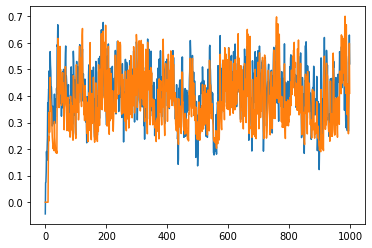

In [14]:
flattened_predictions = y_predicted.flatten()
flattened_true = test_y.flatten()
plt.plot(flattened_predictions)
plt.plot(flattened_true)
plt.show()

In [97]:
len(y_predicted)

1000

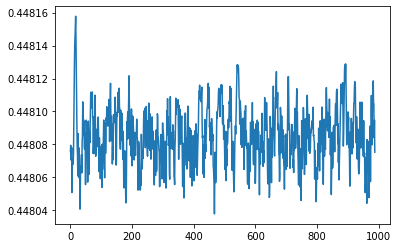

In [162]:
plt.plot(y_predicted)
#flattened_true = test_y.flatten()
#plt.plot(flattened_true)
plt.show()